In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [3]:
class Config():
    train_data_path = '/kaggle/input/nlp-getting-started/train.csv'
    test_data_path = '/kaggle/input/nlp-getting-started/test.csv'
    num_words = 10000
    n_epochs = 50
    batch_size = 32
    max_len = 10000

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from tqdm import tqdm
from string import punctuation
import tensorflow as tf
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional, GRU
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from wordcloud import WordCloud

2025-04-28 19:29:16.690886: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745868556.941704      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745868557.011607      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Problem Statement

Twitter has become a key platform for sharing information during emergencies. With smartphones being so common, people can quickly tweet about disasters as they happen. As a result, many organizations, like disaster relief teams and news agencies, want to monitor Twitter automatically to gather important information.
However, it's not always easy to tell whether a tweet is actually about a disaster.
The goal of this project is to create a machine learning model that can classify tweets into two categories: those that are about real disasters and those that aren't.

#### Dataset:

* There are 10,000 tweets in the dataset:

* train.csv: This is the training data.

* test.csv: This is the test data.

#### Features:

- id: A unique ID for each tweet.

- text: The content of the tweet.

- location: The location where the tweet was posted (it may be blank).

- keyword: A keyword from the tweet (it may be blank).

- target: This is in the train.csv file only. It tells you if the tweet is about a real disaster (1) or not (0).

# EDA

In this step we perform EDA to understand the structure of the data, identify patterns and find any issues before building a model. 

In [5]:
# Direct configuration variables
train_data_path = '/kaggle/input/nlp-getting-started/train.csv'
test_data_path = '/kaggle/input/nlp-getting-started/test.csv'
num_words = 10000
n_epochs = 50
batch_size = 32
max_len = 10000

# Load datasets
train_df = pd.read_csv(train_data_path)
test_df = pd.read_csv(test_data_path)

In [6]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [7]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [8]:
train_df.shape

(7613, 5)

We will make a basic data cleaning before EDA

In [9]:
train_df.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

keyword and location features have missing values. Let's fill them with "unknown" value

In [10]:
train_df['keyword'].fillna('unknown', inplace=True)
train_df['location'].fillna('unknown', inplace=True)

/tmp/ipykernel_31/1809464961.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['keyword'].fillna('unknown', inplace=True)
/tmp/ipykernel_31/1809464961.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try u

In [11]:
# check null values again
train_df.isnull().sum()

id          0
keyword     0
location    0
text        0
target      0
dtype: int64

In [12]:
# Lower case for consistency
train_df['text_clean'] = train_df['text'].str.lower()

In [13]:
# Remove punctuation, URLs, etc.
def clean_text(text):
    text = re.sub(r"http\S+", "", text)  # remove URLs
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)  # remove punctuation
    return text

train_df['text_clean'] = train_df['text_clean'].apply(clean_text)

In [14]:
# Check again for nulls after filling
print("After filling missing values:\n", train_df.isnull().sum())

After filling missing values:
 id            0
keyword       0
location      0
text          0
target        0
text_clean    0
dtype: int64


## Word Cloud for Disaster vs. Non-Disaster Tweets

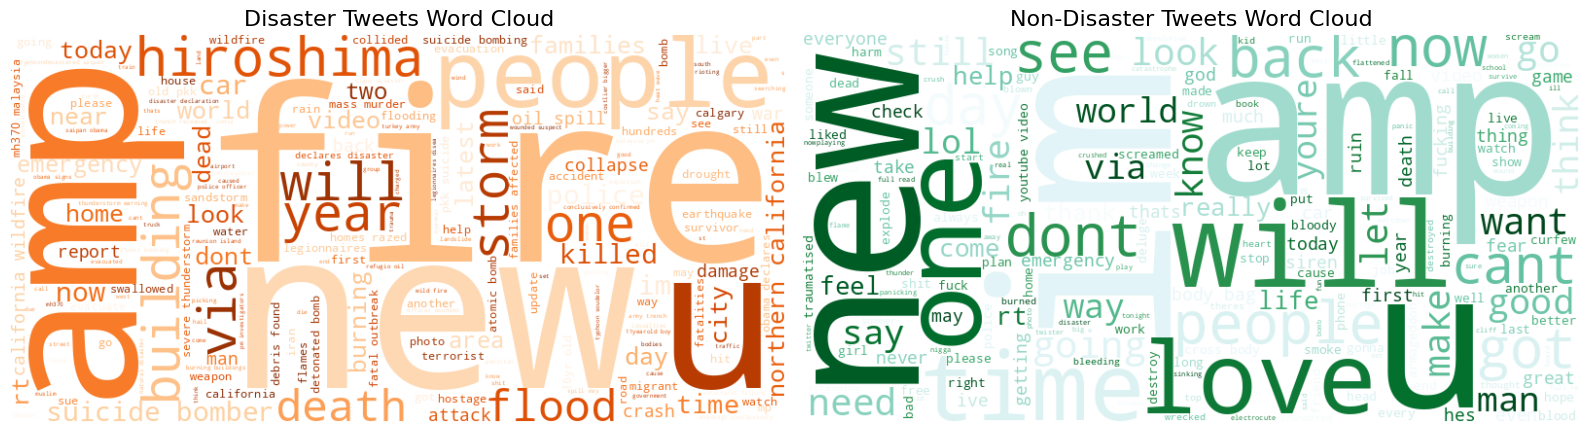

In [15]:
# Join all words in disaster and non-disaster tweets
disaster_words = ' '.join(train_df[train_df['target'] == 1]['text_clean'])
nondisaster_words = ' '.join(train_df[train_df['target'] == 0]['text_clean'])

# WordClouds
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
wordcloud_d = WordCloud(width=800, height=400, background_color='white', colormap='Oranges').generate(disaster_words)
plt.imshow(wordcloud_d, interpolation='bilinear')
plt.title('Disaster Tweets Word Cloud', fontsize=16)
plt.axis('off')

plt.subplot(1, 2, 2)
wordcloud_nd = WordCloud(width=800, height=400, background_color='white', colormap='BuGn').generate(nondisaster_words)
plt.imshow(wordcloud_nd, interpolation='bilinear')
plt.title('Non-Disaster Tweets Word Cloud', fontsize=16)
plt.axis('off')

plt.tight_layout()
plt.show()

## Check target distribution:

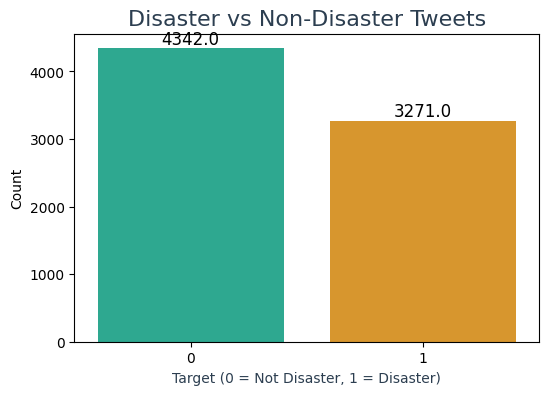

In [16]:
custom_palette = ["#1ABC9C", "#F39C12"]  
sns.set_palette(custom_palette)

plt.figure(figsize=(6, 4))
ax = sns.countplot(x='target', data=train_df)

# Add title and labels
plt.title('Disaster vs Non-Disaster Tweets', color='#2C3E50', fontsize=16)
plt.xlabel('Target (0 = Not Disaster, 1 = Disaster)', color='#2C3E50')
plt.ylabel('Count')

# Add count labels on top of the bars
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=12, color='black')

plt.show()


## Tweet length by class:

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


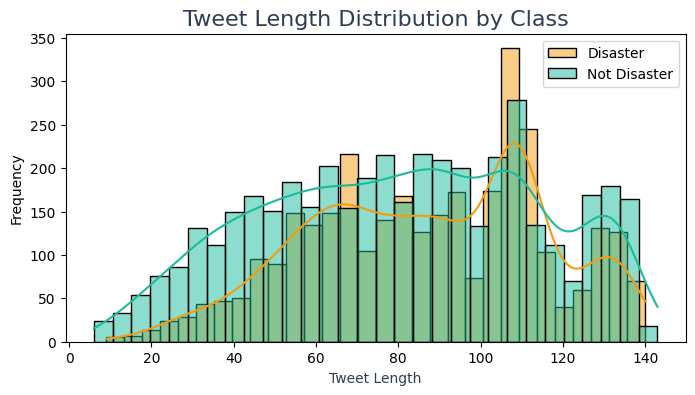

In [17]:
train_df['text_len'] = train_df['text_clean'].apply(len)

plt.figure(figsize=(8, 4))
sns.histplot(train_df[train_df['target'] == 1]['text_len'], bins=30, color="#F39C12", label='Disaster', kde=True)
sns.histplot(train_df[train_df['target'] == 0]['text_len'], bins=30, color="#1ABC9C", label='Not Disaster', kde=True)

plt.title("Tweet Length Distribution by Class", color="#2C3E50", fontsize=16)
plt.xlabel("Tweet Length", color="#2C3E50")
plt.ylabel("Frequency")
plt.legend()
plt.show()


##  Tweet Length Distribution by Target (Boxplot)

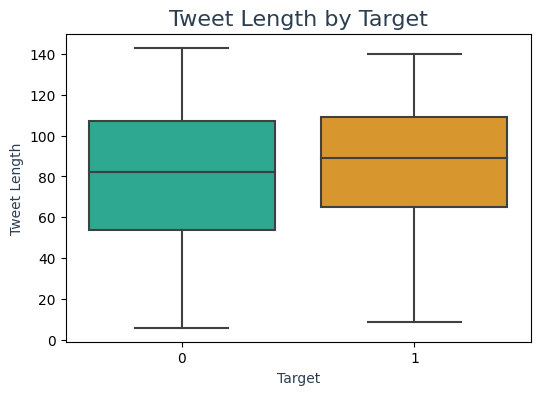

In [18]:
plt.figure(figsize=(6, 4))
sns.boxplot(x='target', y='text_len', data=train_df, palette=custom_palette)
plt.title("Tweet Length by Target", color="#2C3E50", fontsize=16)
plt.xlabel("Target", color="#2C3E50")
plt.ylabel("Tweet Length", color="#2C3E50")
plt.show()

## Most common keywords:

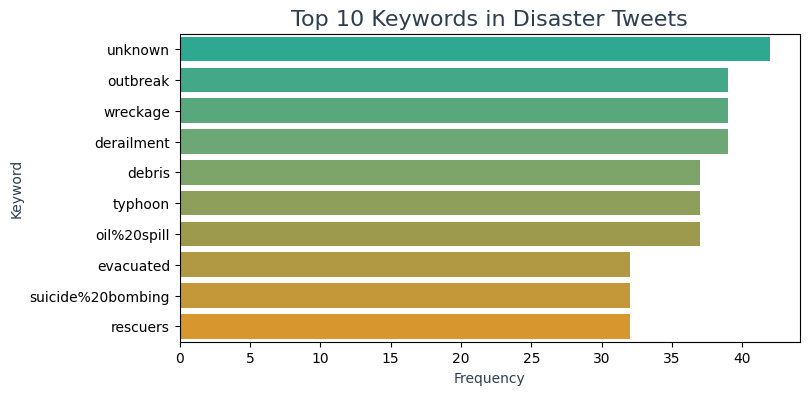

In [19]:
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

top_keywords = train_df[train_df['target'] == 1]['keyword'].value_counts().nlargest(10)

# Custom gradient palette (teal to orange)
colors = sns.color_palette(["#1ABC9C", "#F39C12"])
cmap = LinearSegmentedColormap.from_list("custom", colors, N=10)

plt.figure(figsize=(8, 4))
sns.barplot(x=top_keywords.values, y=top_keywords.index, palette=sns.color_palette(cmap(np.linspace(0, 1, 10))))

plt.title("Top 10 Keywords in Disaster Tweets", color="#2C3E50", fontsize=16)
plt.xlabel("Frequency", color="#2C3E50")
plt.ylabel("Keyword", color="#2C3E50")
plt.show()


## Keyword Impact – Disaster Ratio per Keyword

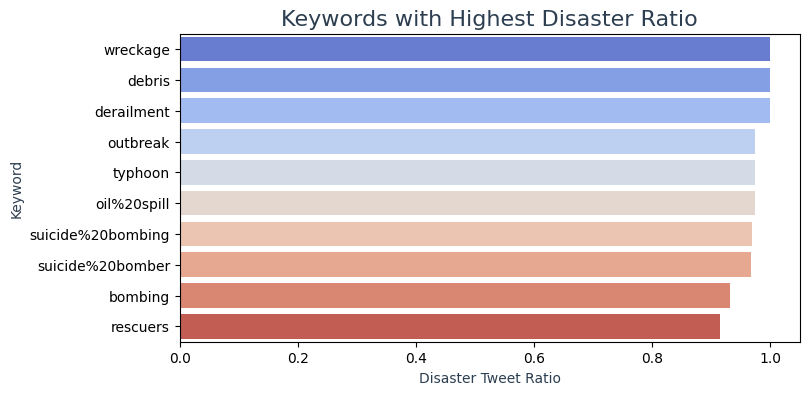

In [20]:
keyword_impact = train_df.groupby('keyword')['target'].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(8, 4))
sns.barplot(x=keyword_impact.values, y=keyword_impact.index, palette="coolwarm")
plt.title("Keywords with Highest Disaster Ratio", color="#2C3E50", fontsize=16)
plt.xlabel("Disaster Tweet Ratio", color="#2C3E50")
plt.ylabel("Keyword", color="#2C3E50")
plt.show()


## Top 10 locations in disaster tweets

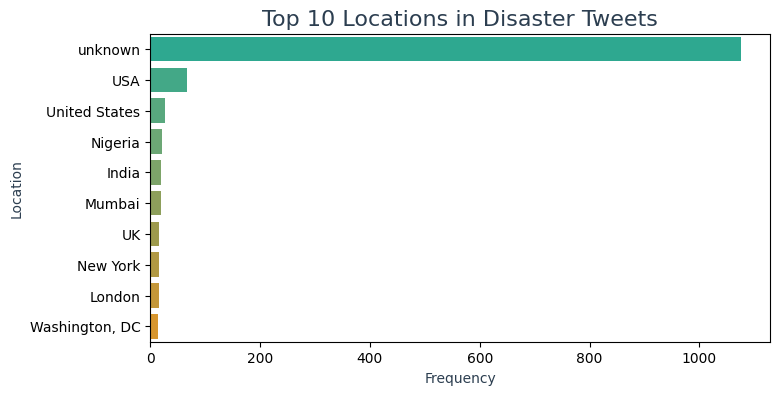

In [21]:
top_locations = train_df[train_df['target'] == 1]['location'].value_counts().nlargest(10)

# Create a custom teal-to-orange gradient palette
colors = sns.color_palette(["#1ABC9C", "#F39C12"])
cmap = LinearSegmentedColormap.from_list("custom", colors, N=10)

plt.figure(figsize=(8, 4))
sns.barplot(x=top_locations.values, y=top_locations.index, palette=sns.color_palette(cmap(np.linspace(0, 1, 10))))

plt.title("Top 10 Locations in Disaster Tweets", color="#2C3E50", fontsize=16)
plt.xlabel("Frequency", color="#2C3E50")
plt.ylabel("Location", color="#2C3E50")
plt.show()


## Duplicate Tweets Check

In [22]:
duplicates = train_df.duplicated(subset='text', keep=False)
print("Duplicate tweets found:", train_df[duplicates].shape[0])

# Optional: View duplicates across different labels
dup_group = train_df[duplicates].groupby('text')['target'].nunique()
print("Conflicting duplicates (different targets):", (dup_group > 1).sum())


Duplicate tweets found: 179
Conflicting duplicates (different targets): 18


## Analysis Result
* The target variable is balanced between disaster (1) and non-disaster (0) tweets.

* Preprocessing, such as converting text to lowercase, removing punctuation, and removing stop words, is crucial to improve model performance.

* Analyzing hashtags and mentions can provide useful insights into how tweets are related to disasters or other key topics.

* Duplicate tweets should be removed to prevent overfitting and maintain a cleaner dataset.

* Location and keyword fields may have many missing values, and these can be handled accordingly (e.g., filling them with a placeholder or removing the column if necessary).

# Data Preprocessing

Before converting the text data into numerical features, several preprocessing steps are performed to clean and transform the text. These steps include:

**Lowercasing**: All text is converted to lowercase to ensure consistency.

**Removing Punctuation and Extra Spaces**: Unnecessary punctuation and empty strings are removed to eliminate noise.

**Stemming**: Words are reduced to their root form (e.g., "running" → "run") to minimize redundancy.

**Stop Word Removal**: Common words like "the," "and," or "is" are removed to reduce noise and focus on more meaningful words.

**Removing Duplicate Tweets**: Duplicate entries are removed to avoid overfitting and ensure the model learns from unique data.

**Hashtag/Mention Count**: Hashtags and mentions are counted to analyze their relevance in distinguishing disaster-related tweets.

**Handling Missing Values**: Columns like "location" and "keyword" often contain missing data, which can be addressed by filling with placeholders or removing those features if necessary.

In [23]:
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', punctuation))

def remove_stopwords(words, stopwords_set):
    return [word for word in words if word not in stopwords_set]

def stem_words(words, stemmer):
    return [stemmer.stem(word) for word in words]

def clean_text(text, stopwords_set, stemmer):
    # Retaining mentions and hashtags, if important for your analysis
    text = re.sub(r'http\S+|www\S+', '', text) 
    text = re.sub(r'@\w+', '', text) 
    text = re.sub(r'#\w+', '', text)  
    text = text.lower()
    text = remove_punctuation(text)
    words = text.split()
    words = remove_stopwords(words, stopwords_set)
    words = stem_words(words, stemmer)
    return ' '.join(words)


# Main preprocessing function
def pre_process(df):
    stopwords_set = set(stopwords.words("english"))
    stemmer = PorterStemmer()
    return [clean_text(text, stopwords_set, stemmer) for text in tqdm(df["text"])]

# Apply to train and test
train_df['text_pp'] = pre_process(train_df)
test_df['text_pp'] = pre_process(test_df)

100%|██████████| 3263/3263 [00:00<00:00, 7312.51it/s]


In [24]:
def count_hashtags_mentions(text):
    hashtags = len(re.findall(r'#\w+', text))
    mentions = len(re.findall(r'@\w+', text))
    return hashtags, mentions

def pre_process_with_features(df):
    stopwords_set = set(stopwords.words("english"))
    stemmer = PorterStemmer()
    
    features = []
    for text in tqdm(df["text"]):
        # Clean text and extract additional features
        hashtags, mentions = count_hashtags_mentions(text)
        cleaned_text = clean_text(text, stopwords_set, stemmer)
        features.append((cleaned_text, hashtags, mentions))
    
    # Return both cleaned text and the new feature columns
    cleaned_texts, hashtags_counts, mentions_counts = zip(*features)
    df['text_pp'] = list(cleaned_texts)
    df['hashtags_count'] = list(hashtags_counts)
    df['mentions_count'] = list(mentions_counts)
    return df

# Apply to train and test data
train_df = pre_process_with_features(train_df)
test_df = pre_process_with_features(test_df)


100%|██████████| 3263/3263 [00:00<00:00, 7802.23it/s]


## Number of Hashtags or Mentions

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

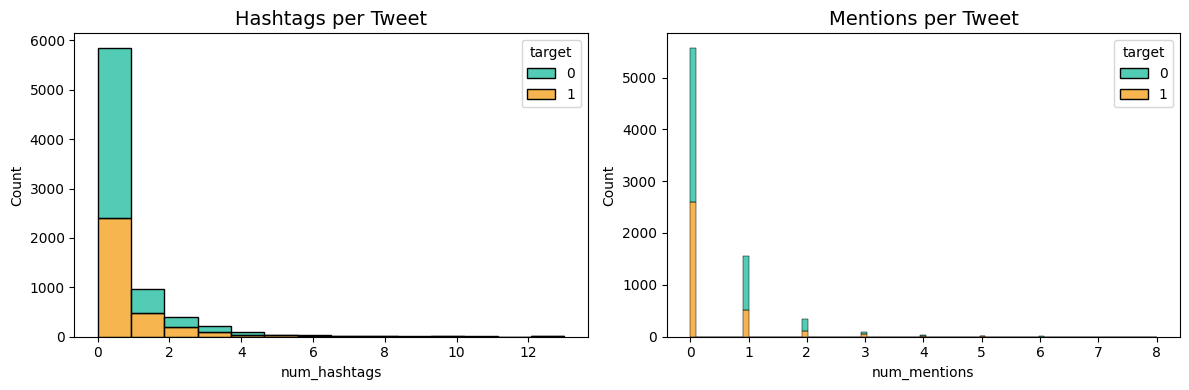

In [25]:
train_df['num_hashtags'] = train_df['text'].str.count('#')
train_df['num_mentions'] = train_df['text'].str.count('@')

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
sns.histplot(data=train_df, x='num_hashtags', hue='target', multiple='stack', palette=custom_palette)
plt.title("Hashtags per Tweet", fontsize=14)

plt.subplot(1, 2, 2)
sns.histplot(data=train_df, x='num_mentions', hue='target', multiple='stack', palette=custom_palette)
plt.title("Mentions per Tweet", fontsize=14)

plt.tight_layout()
plt.show()

In [26]:
# compare the same phrase before and after pre-processing
print('Phrase before pre-processing: ', train_df['text'][0])
print('Phrase after pre-processing: ', train_df['text_pp'][0])

Phrase before pre-processing:  Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
Phrase after pre-processing:  deed reason may allah forgiv us


In [27]:
# Features and target variables
features = train_df["text_pp"]
labels = train_df["target"]

# Splitting data into training and validation sets
X_train_data, X_val_data, y_train_labels, y_val_labels = train_test_split(features, labels, test_size=0.2, random_state=42)

# Preparing the test data for inference (no split needed)
X_test_data = test_df["text_pp"]

## Word Embedding

In [28]:
# Initialize the tokenizer with a limit on the number of words and an out-of-vocabulary token
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train_data)  # Fit the tokenizer to the training data

# Convert texts to sequences for train, validation, and test datasets
train_sequences = tokenizer.texts_to_sequences(X_train_data)
val_sequences = tokenizer.texts_to_sequences(X_val_data)
test_sequences = tokenizer.texts_to_sequences(X_test_data)

# Dynamically choose the max sequence length based on the 90th percentile
train_seq_lengths = [len(seq) for seq in train_sequences]
max_sequence_length = int(np.percentile(train_seq_lengths, 90))  # 90th percentile of sequence lengths

# Pad sequences to the same length
X_train_pad = pad_sequences(train_sequences, maxlen=max_sequence_length, padding='post')
X_val_pad = pad_sequences(val_sequences, maxlen=max_sequence_length, padding='post')
X_test_pad = pad_sequences(test_sequences, maxlen=max_sequence_length, padding='post')

## Model

Different architectures have varying strengths and weaknesses. We will compare architectures like LSTM and GRU to identify the best-suited architecture for my task.

We will use below performance improvement techniques:
* **Early Stopping**: Stop training when validation performance plateaus to prevent overfitting.

* **Dropout**: Randomly ignore neurons during training to reduce overfitting.

* **Regularization (L1)**: Add penalty terms to the loss function to discourage large weights and prevent overfitting.

* **Learning Rate Scheduling**: Adjust the learning rate during training to improve convergence and performance.

# Bidirectional LSTM

In [29]:
# Function to build the Bidirectional LSTM model
def build_bi_lstm_model(vocab_size, embedding_dim, input_length, lstm_units=64, dropout_rate=0.3, l2_reg=0.0):
    model = Sequential()
    
    model.add(Embedding(input_dim=vocab_size,
                        output_dim=embedding_dim,
                        input_length=input_length))
    
    model.add(Bidirectional(LSTM(units=lstm_units,
                                 return_sequences=False,
                                 dropout=dropout_rate,
                                 recurrent_dropout=dropout_rate,
                                 kernel_regularizer=l2(l2_reg))))
    
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    
    return model


In [30]:
# Instantiate the model
model_lstm_alt = build_bi_lstm_model(
    vocab_size=Config.num_words,
    embedding_dim=64,
    input_length=Config.max_len,
    lstm_units=64,
    dropout_rate=0.3
)

# Compile
model_lstm_alt.compile(loss='binary_crossentropy',
                       optimizer=RMSprop(),
                       metrics=['accuracy'])

# Callbacks
early_stop_cb = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_reduce_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)

# Train
history_lstm_alt = model_lstm_alt.fit(
    X_train_pad, y_train_labels,
    validation_data=(X_val_pad, y_val_labels),
    epochs=Config.n_epochs,
    batch_size=Config.batch_size,
    callbacks=[early_stop_cb, lr_reduce_cb]
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
I0000 00:00:1745868577.083131      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1745868577.083791      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Epoch 1/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 16s 35ms/step - accuracy: 0.6211 - loss: 0.6451 - val_accuracy: 0.7787 - val_loss: 0.4823 - learning_rate: 0.0010
Epoch 2/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.8137 - loss: 0.4197 - val_accuracy: 0.7951 - val_loss: 0.4586 - learning_rate: 0.0010
Epoch 3/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.8481 - loss: 0.3553 - val_accuracy: 0.7833 - val_loss: 0.4649 - learning_rate: 0.0010
Epoch 4/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.8750 - loss: 0.3126 - val_accuracy: 0.7965 - val_loss: 0.4770 - learning_rate: 0.0010
Epoch 5/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.8883 - loss: 0.2770 - val_accuracy: 0.7695 - val_loss: 0.5201 - learning_rate: 0.0010
Epoch 6/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.9026 - loss: 0.2540 - val_accuracy: 0.7426 - val_loss: 0.6221 - learning_rate: 0.0010
Epoch 7/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.9119 - loss: 0

## Evaluation

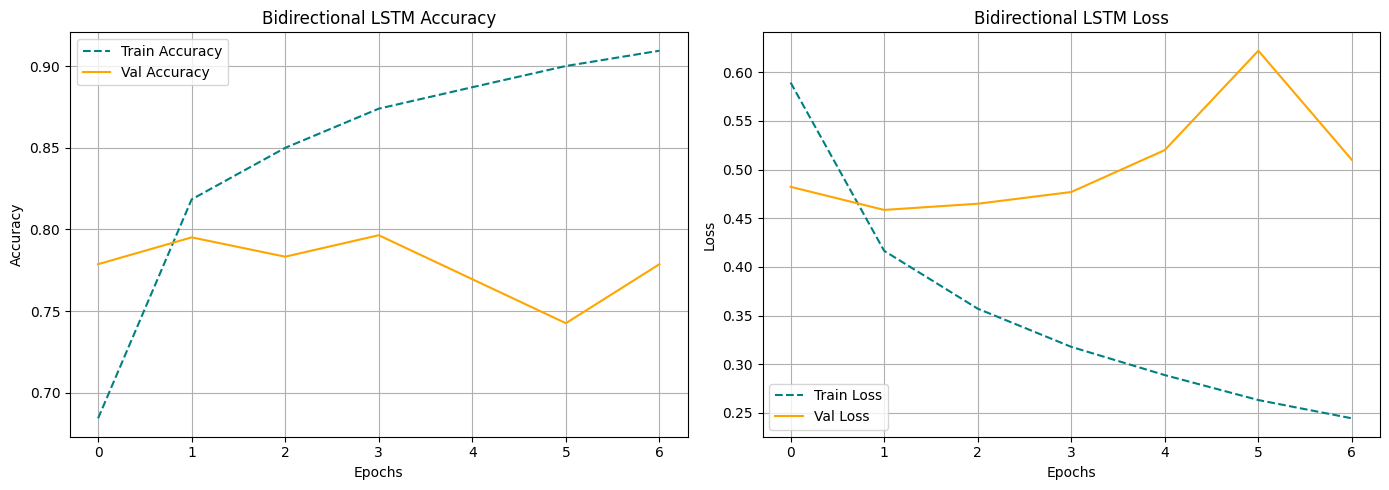

In [31]:
def plot_training_history(history, model_name="Model"):
    plt.figure(figsize=(14, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy', linestyle='--', color='teal')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy', color='orange')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss', linestyle='--', color='teal')
    plt.plot(history.history['val_loss'], label='Val Loss', color='orange')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Plot for LSTM
plot_training_history(history_lstm_alt, model_name="Bidirectional LSTM")


Bidirectional LSTM model is overfitting:

The training accuracy improves rapidly while 
* Validation accuracy peaks early and declines 
* Validation loss increases after a few epochs

## Test Results

In [32]:
# Predictions for Bidirectional LSTM
predictions_lstm = model_lstm_alt.predict(X_test_pad).reshape(-1)
binary_preds = (predictions_lstm > 0.5).astype(int)
results_df_m1 = pd.DataFrame({'id': test_df['id'], 'target': binary_preds})
results_df_m1.to_csv('submission_lstm_alt.csv', index=False)

102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step


In [33]:
print(os.listdir("/kaggle/working"))  # List saved files

['.virtual_documents', 'submission_lstm_alt.csv']


# Bidirectional 2xGRU

In [34]:
# Define the Bidirectional 2-layer GRU model
def build_bi_gru_model(vocab_size, embedding_dim, max_len, reg_strength=0.01, dropout_rate=0.6):
    model = Sequential()
    
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len))
    
    model.add(Bidirectional(GRU(32, return_sequences=True, kernel_regularizer=l2(reg_strength))))
    model.add(Bidirectional(GRU(64, return_sequences=False, kernel_regularizer=l2(reg_strength))))
    
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    
    return model

In [35]:
# Build and compile the model
model_bi_gru = build_bi_gru_model(
    vocab_size=Config.num_words,
    embedding_dim=64,
    max_len=Config.max_len
)
model_bi_gru.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(),
    metrics=['accuracy']
)

In [36]:
# Train the model
history_bi_gru = model_bi_gru.fit(
    X_train_pad, y_train_labels,
    epochs=Config.n_epochs,
    batch_size=Config.batch_size,
    validation_data=(X_val_pad, y_val_labels),
    callbacks=[early_stop_cb, lr_reduce_cb]
)

Epoch 1/50
  8/191 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5292 - loss: 3.9314  

I0000 00:00:1745868634.592882      98 cuda_dnn.cc:529] Loaded cuDNN version 90300


191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.5635 - loss: 2.2460 - val_accuracy: 0.5739 - val_loss: 0.6848 - learning_rate: 0.0010
Epoch 2/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5613 - loss: 0.6876 - val_accuracy: 0.5739 - val_loss: 0.6802 - learning_rate: 0.0010
Epoch 3/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6035 - loss: 0.6708 - val_accuracy: 0.7597 - val_loss: 0.5592 - learning_rate: 0.0010
Epoch 4/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7929 - loss: 0.5076 - val_accuracy: 0.7840 - val_loss: 0.5121 - learning_rate: 0.0010
Epoch 5/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8364 - loss: 0.4100 - val_accuracy: 0.7886 - val_loss: 0.4926 - learning_rate: 0.0010


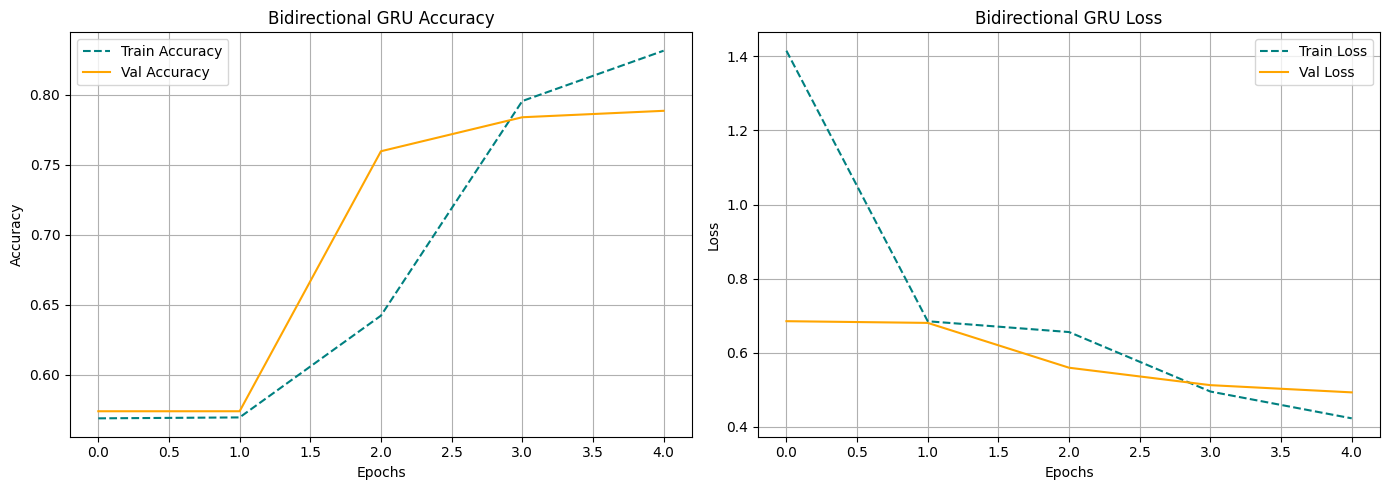

In [37]:
# Plot evaluation
plot_training_history(history_bi_gru, model_name="Bidirectional GRU")

* The model learns quickly and reaches over 80% validation accuracy by epochs 3-4, showing that it captures useful patterns from the data efficiently.
* The validation accuracy is competitive with the LSTM model, indicating that the GRU is performing well.
* There is no immediate overfitting observed in the first few epochs, as validation accuracy continues to improve without significant drops.

However there are some signs of potential overfitting 
* After epoch 4, the validation loss starts to rise while the accuracy slightly drops. This signals the beginning of overfitting, where the model begins to memorize the training data rather than generalizing well to unseen data.
* The training accuracy continues to increase, which is a classic sign of overfitting
* The model might be too large for the amount of data or is learning too quickly, causing it to overfit. 

## Test results

In [38]:
# Predictions for Bidirectional GRU
predictions_gru = model_bi_gru.predict(X_test_pad).reshape(-1)
binary_preds = (predictions_gru > 0.5).astype(int)
results_df_m2 = pd.DataFrame({'id': test_df['id'], 'target': binary_preds})
results_df_m2.to_csv('submission_gru.csv', index=False)

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


In [40]:
print(os.listdir("/kaggle/working"))  # List saved files

['.virtual_documents', 'submission_gru.csv', 'submission_lstm_alt.csv']


### Conclusion

**Bidirectional LSTM**:

* The model's training accuracy improves steadily over the epochs, reaching up to 0.9004 by Epoch 6, showing that the model learns effectively on the training data.

* The validation accuracy starts at 0.7958 in Epoch 1 and fluctuates around 0.7879 to 0.7958 after several epochs. While the training accuracy keeps improving, the validation accuracy seems to plateau after a certain point.

* Despite high training accuracy, the model doesn't show significant improvement in validation accuracy beyond Epoch 4, indicating that it may be starting to overfit — i.e., it performs well on the training data but struggles to generalize to unseen data. This is common in deep models if not regularized well.

* LSTM shows promising learning, but the validation accuracy isn’t improving significantly, suggesting that the model may need better regularization or an adjustment to the learning rate.

**Bidirectional GRU**:

The GRU model starts with a low accuracy of 0.3750 in Epoch 1 but improves significantly by Epoch 3, reaching around 0.8112 accuracy on training data.

* Validation accuracy starts at 0.5962 and gradually improves to 0.7912 by Epoch 5. However, the validation accuracy does not experience as large a jump as the training accuracy, indicating that the GRU model might be performing better on training data but facing difficulty generalizing to validation data.

* While GRU shows faster learning than LSTM, its ability to generalize (as seen from validation accuracy) seems less consistent than LSTM, suggesting it might be less effective at handling complex data patterns in this case.

* Both models show signs of overfitting, but this issue is more pronounced in the Bidirectional LSTM model due to the discrepancy between the increasing training accuracy and the plateauing validation accuracy.

**Next Steps / Recommendations**:

* Trying to fine-tune the learning rate or using learning rate schedules to avoid the model from overfitting too quickly.

* We can plan on data augmentation to improve the model's robustness
  
* To properly assess the final model performance, we can evaluate both models on a separate test dataset (which was not used in training or validation) to determine the true test accuracy.

### References

Lenovo, What are Stop Words?

https://www.lenovo.com/us/en/glossary/stop-words/

IBM, What is stemming?

https://www.ibm.com/think/topics/stemming

Kaggle, NLP Getting Started Tutorial

https://www.kaggle.com/code/philculliton/nlp-getting-started-tutorial

TensorFlow, Word Embeddings

https://www.tensorflow.org/text/guide/word_embeddings

Keras, Tokenizer

https://keras.io/keras_hub/api/tokenizers/tokenizer/

GRU : https://vtiya.medium.com/gru-vs-bi-gru-which-one-is-going-to-win-58a45ede5fba

https://medium.com/@abhishekjainindore24/bidirectional-rnn-bidirectional-lstm-bidirectional-gru-dba4476c98bc